# LINCC Frameworks `nested-pandas`/`nested-dask` Review Demo


## `nested-pandas` Overview

In [ ]:
# To install the needed packages for this demo, run this cell
%pip install nested_dask light_curve astropy --quiet

### The NestedFrame Interface

The core idea of `nested-pandas` is the ability to "nest" DataFrames within DataFrames. Below, we load some Object and Source data using `nested-pandas`:

In [6]:
import nested_pandas as npd

# Read parquet from the native Pandas interface is available, just as the rest of the Pandas API
object_df = npd.read_parquet("objects.parquet")
source_df = npd.read_parquet("ztf_sources.parquet").sort_index()

# Add a "ztf_sources" column of all tied sources to each object
object_nf = object_df.add_nested(source_df, "ztf_sources")
object_nf

,ra,dec,ztf_sources
0,17.447868,35.547046,mjd flux band 0 8.420511...
1,1.020437,4.353613,mjd flux band 0 15.019776...
2,3.695975,31.130105,mjd flux band 0 13.168814...
3,13.242558,6.099142,mjd flux band 0 18.708019...
4,2.744142,48.444456,mjd flux band 0 1.035325...
...,...,...,...
995,6.547263,40.249140,mjd flux band 0 17.260228...
996,18.391919,17.643616,mjd flux band 0 18.159739...
997,18.587638,46.568135,mjd flux band 0 7.700205...
998,10.871655,6.719466,mjd flux band 0 0.886458...


Our DataFrame (or "NestedFrame" for `nested-pandas`) now has a new column which contains the full contents of our source table. Every row now has a DataFrame of nested source information available to it. For example, let's look at the first row:

In [7]:
# The dataframe has all ztf_source rows for object 0
object_nf.loc[0]["ztf_sources"]

,mjd,flux,band
0,8.420511,259.454128,r
1,14.442831,29.947062,g
2,17.276088,250.422340,r
3,11.874109,0.395589,g
4,15.418783,228.769717,g
...,...,...,...
995,6.206966,41.100829,g
996,0.181429,217.918431,g
997,15.897106,224.327657,g
998,5.327694,217.656239,r


As an extension of `pandas`, the full pandas interface is available to `nested-pandas` users. The API has been built out to support handling of nested columns, with a few examples shown next:

#### Applying Operations Directly to Nested Data

In [8]:
# nested_layer.column syntax allows access to sub-queries
object_nf_g = object_nf.query("ztf_sources.band == 'g'")
object_nf_g

,ra,dec,ztf_sources
0,17.447868,35.547046,mjd flux band 0 14.442831...
1,1.020437,4.353613,mjd flux band 0 15.019776...
2,3.695975,31.130105,mjd flux band 0 13.168814...
3,13.242558,6.099142,mjd flux band 0 0.911046...
4,2.744142,48.444456,mjd flux band 0 7.315952...
...,...,...,...
995,6.547263,40.249140,mjd flux band 0 8.131266...
996,18.391919,17.643616,mjd flux band 0 17.188258...
997,18.587638,46.568135,mjd flux band 0 7.700205...
998,10.871655,6.719466,mjd flux band 0 0.886458...


In [9]:
# The dataframes nested in "ztf_sources" now only contain g-band observations
object_nf_g.loc[0]["ztf_sources"]

,mjd,flux,band
0,14.442831,29.947062,g
1,11.874109,0.395589,g
2,15.418783,228.769717,g
3,2.557222,75.081593,g
4,13.989636,126.599935,g
...,...,...,...
488,5.904323,299.269974,g
489,13.271755,101.348946,g
490,6.206966,41.100829,g
491,0.181429,217.918431,g


#### Run Custom User Functions with `reduce`

`reduce` is a flexible function that applys a function to each row of the NestedFrame (similar to `pandas` `apply`), with the additional capability of using nested columns in those function calls.

In [10]:
import numpy as np
# Define a custom user function
def my_mean_func(fluxes):
    """A custom function to calculate the mean flux"""
    return {"mean_flux": np.mean(fluxes)}

# Find the mean g-band flux for each object
object_nf_g.reduce(my_mean_func, "ztf_sources.flux")

,mean_flux
0,146.386013
1,149.530865
2,158.365247
3,150.590805
4,154.176187
...,...
995,148.844946
996,149.470083
997,153.178028
998,150.725953


Writing functions for `reduce` is easy, as `reduce` packages input data in common python data structures:

In [18]:
# Our function recieves base column values as single values, and nested column values as a numpy array of values
def show_inputs(base_column, nested_column):
    """A custom function to calculate the mean flux"""
    return {"base_column_input": base_column,
           "nested_column_input": nested_column}

object_nf_g.reduce(show_inputs, "ra", "ztf_sources.mjd").head(5)    

,base_column_input,nested_column_input
0,17.447868,"[14.442830695475122, 11.874109343340809, 15.41..."
1,1.020437,"[15.019776119882977, 16.27592751795432, 19.524..."
2,3.695975,"[13.168813738794169, 11.025383492549292, 19.73..."
3,13.242558,"[0.911046210332267, 14.66964087052855, 16.3460..."
4,2.744142,"[7.315951527439497, 16.938198163131343, 4.7169..."


### Internals: Powering Efficient Data Analysis with `pyarrow`

"Dataframes within Dataframes" is a useful hueristic for understanding the API/workings of a NestedFrame. However, the actual storage representation leverages `pyarrow` (a package that contains a set of technologies that enable data systems to efficiently store, process, and move data) and materializes the nested dataframes as a view of the data. The following diagram details the actual storage representation of `nested-pandas`:

<center><img src="./npd_internals.png"/></center>

### Performance Impact of `nested-pandas`

The design of `nested-pandas` yields significant speedups over using `pandas` native workflows in many cases. Below is a brief example workflow comparison between `pandas` and `nested-pandas`, where this example workflow calculates the amplitude of fluxes after a few filtering steps.

In [9]:
from nested_pandas.utils import count_nested
from nested_pandas import read_parquet
import pandas as pd

# pip install --only-binary=light-curve light-curve for older Mac OS versions
from light_curve import Amplitude
amplitude = Amplitude()

#### `pandas`

In [27]:
%%timeit

# Read data
object_df = pd.read_parquet("objects.parquet")
source_df = pd.read_parquet("ztf_sources.parquet").sort_index()

# Filter on object
filtered_object = object_df.query("ra > 10.0")
#sync object to source --removes any index values of source not found in object
filtered_source = filtered_object[[]].join(source_df, how="left")

# Count nobs per photometric band and add it to the object table
band_counts = source_df.groupby(level=0).apply(lambda x: 
                                               x[["band"]].value_counts().reset_index()).pivot_table(values="count", 
                                                                                                     index="index", 
                                                                                                     columns="band", 
                                                                                                     aggfunc="sum")
filtered_object = filtered_object.join(band_counts[["g","r"]])

# Filter on our nobs
filtered_object = filtered_object.query("g > 520")
filtered_source = filtered_object[[]].join(source_df, how="left")

# Calculate Amplitude
filtered_source.groupby(level=0).apply(lambda x: amplitude(np.array(x.mjd), np.array(x.flux)))

569 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### `nested-pandas`

In [10]:
%%timeit

#Read in parquet data
#nesting sources into objects
nf = read_parquet(
data="objects.parquet",
to_pack={"ztf_sources": "ztf_sources.parquet"})

# Filter on object
nf = nf.query("ra > 10.0")

# Count nobs per photometric band and add it as a column
nf = count_nested(nf, "ztf_sources", by="band", join=True)

# Filter on our nobs
nf = nf.query("n_ztf_sources_g > 520")

# Calculate Amplitude
nf.reduce(amplitude, "ztf_sources.mjd", "ztf_sources.flux")

237 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In this example, `nested-pandas` has improved the speed of computation by ~2x and also reduced the overall code footprint of the workflow. As a relatively simple workflow, this is a conservative example of the performance gains of `nested-pandas` as in more complex workflows we expect to see more and more `joins` and `groupbys` in a native `pandas` workflow that are avoided in `nested-pandas`.

## Addressing Scale: `nested-dask`

The row-by-row optimizations introduced in `nested-pandas` are vital to efficiently work at scale. However, just as `pandas` is largely limited to in-memory datasets, so is `nested-pandas`.

`dask` is a package that equips `pandas` with the ability to work at scale, by:

* Providing built-in parallelization and larger-than-memory computation of workflows
* Introducing "lazy" computation, where operations are tracked and run only when data is needed/requested
* Providing dashboarding utility to help users monitor/debug their active workflows

This motivates the LINCC-Frameworks package, `nested-dask`, to bring the efficiency gains of `nested-pandas` to the scale of Rubin.

### `nested-dask` Showcase: Eclipsing Binary Search in the PLAsTiCC dataset


The API of `nested-dask` follows the API of Nested-Pandas closely, and as such we'll show `nested-dask` 

The goal of the workflow is to identify a subset of Eclipsing Binary Candidates within the dataset.

Photometric LSST Astronomical Time-Series Classification Challenge (PLAsTiCC)

* 3,492,890 Objects
* 453,653,104 Sources

In [1]:
import nested_dask as nd
import numpy as np
import light_curve as licu

# Setting up a Dask Client allows us to define the used compute resources
from dask.distributed import Client
client = Client(n_workers=4,
                dashboard_address=':39876')

# Not available externally
DATA_DIR = "/Users/dbranton/lincc/timeseries/data/plasticc/parquet"

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39876/status,
Dashboard: http://127.0.0.1:39876/status,Workers: 4
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58114,Workers: 4
Dashboard: http://127.0.0.1:39876/status,Total threads: 12
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:58125,Total threads: 3
Dashboard: http://127.0.0.1:58130/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:58117,


In [2]:
%%time
# Load in Plasticc data
object_ndf = nd.read_parquet(DATA_DIR+"/object/*.parquet", 
                         dtype_backend="pyarrow", 
                         index="object_id",
                         calculate_divisions=True,
                         columns=["ra", "decl","hostgal_photoz"])
source_ndf = nd.read_parquet(DATA_DIR+"/source/*.parquet", 
                         dtype_backend="pyarrow",
                         index="object_id",
                         calculate_divisions=True,)

# Nesting Sources in Object
objsor_ndf = object_ndf.add_nested(source_ndf, "source")

CPU times: user 23.5 ms, sys: 10.8 ms, total: 34.3 ms
Wall time: 38.9 ms


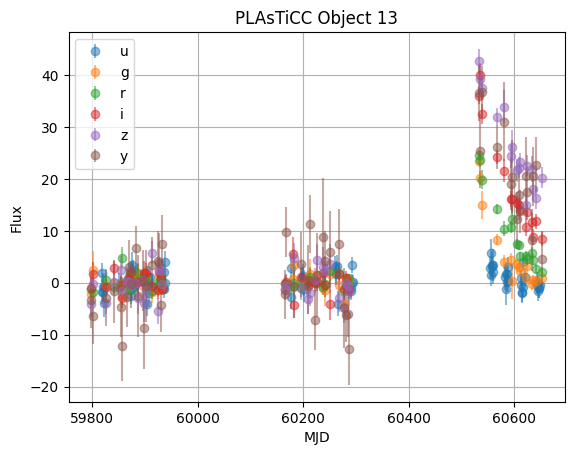

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Grab the source dataframe for the first object
obj = objsor_ndf.head(1).iloc[0]
lc = obj.source

for band in np.unique(lc.passband):
    band_mask = lc.passband == band
    band_labels = ["u","g","r","i","z","y"]
    plt.errorbar(lc.mjd[band_mask], lc.flux[band_mask], yerr=lc.flux_err[band_mask], fmt='o', alpha=0.5, label=band_labels[band])

plt.title(f"PLAsTiCC Object {obj.name}")
plt.ylabel("Flux")
plt.xlabel("MJD")
plt.grid()
plt.legend()

First, let's select only Galactic objects, by cutting on redshift:

In [4]:
%%time
objsor_ndf = objsor_ndf.query("hostgal_photoz < 0.001")

CPU times: user 10.7 ms, sys: 3.09 ms, total: 13.8 ms
Wall time: 11.1 ms


Second, let's select persistent sources, by cutting on the duration of the light curve:

In [5]:
%%time
def calc_ptp(time, detected):
    try:
        return {"duration": np.ptp(time[np.asarray(detected, dtype=bool)])}
    except ValueError:
        return {"duration": 0}

duration = objsor_ndf.reduce(calc_ptp, 'source.mjd', 'source.detected_bool',
                         meta={"duration":"float"})
# Filter by the calculated duration
objsor_ndf = objsor_ndf.assign(duration=duration["duration"])
objsor_ndf = objsor_ndf.query("duration > 366")

CPU times: user 19.9 ms, sys: 3.54 ms, total: 23.4 ms
Wall time: 23.1 ms


Next, we use Otsu's method to split light curves into two groups: one with high flux, and one with low flux. Eclipsing binaries should have lower flux group smaller than the higher flux group, but having larger variability. For simplicity, we only calculate these features for the i (3) band.

In [6]:
%%time

def otsu_fmt(*args, **kwargs):
    otsu = licu.OtsuSplit()
    res = otsu(*args, **kwargs)
    return {'otsu_mean_diff': res[0],
           'otsu_std_lower': res[1],
           'otsu_std_upper': res[2],
            'otsu_lower_to_all_ratio': res[3]}

objsor_ndf_3 = objsor_ndf.query("source.passband == 3")
otsu_features = objsor_ndf_3.reduce(otsu_fmt, 'source.mjd', 'source.flux',
                               meta={'otsu_mean_diff': float,
                                     'otsu_std_lower': float,
                                     'otsu_std_upper': float,
                                     'otsu_lower_to_all_ratio': float,})
# Assign Columns
objsor_ndf = objsor_ndf.assign(
    otsu_lower_to_all_ratio=otsu_features['otsu_lower_to_all_ratio'],
    otsu_std_lower=otsu_features['otsu_std_lower'],
    otsu_std_upper=otsu_features['otsu_std_upper'],
)
# Filter by Otsu Features
objsor_ndf = objsor_ndf.query(
    "otsu_lower_to_all_ratio < 0.1 and otsu_std_lower > otsu_std_upper",
)

CPU times: user 27.1 ms, sys: 5.01 ms, total: 32.2 ms
Wall time: 44 ms


And finally, we can call compute to kick off the computation:

In [7]:
%%time
objsor_df = objsor_ndf.compute()

CPU times: user 2.6 s, sys: 330 ms, total: 2.93 s
Wall time: 9.38 s


In [9]:
objsor_df.sort_values(by="duration")

,ra,decl,hostgal_photoz,source,duration,otsu_lower_to_all_ratio,otsu_std_lower,otsu_std_upper
object_id,,,,,,,,
5018697,89.2781,-55.2994,0.0,mjd passband flux flux_er...,366.0269,0.090909,20.334780,11.308998
107162588,103.1836,-27.2796,0.0,mjd passband flux flux_er...,366.9459,0.083333,59.450195,13.847480
81231667,79.8047,-36.6092,0.0,mjd passband flux flux_er...,367.0785,0.086957,18.588678,12.536847
70340192,33.9663,-51.2558,0.0,mjd passband flux flux_er...,367.8194,0.086957,15.041311,7.034880
19873025,318.1641,-19.6296,0.0,mjd passband flux flux_er...,368.2259,0.090909,61.010877,5.875888
...,...,...,...,...,...,...,...,...
106757404,89.6484,-14.6317,0.0,mjd passband flux flux...,1092.0558,0.095238,788.793971,766.733326
33018320,140.75,-56.6372,0.0,mjd passband flux flux_e...,1092.8183,0.095238,305.746429,168.038220
71851699,146.2941,-42.0104,0.0,mjd passband flux flux_e...,1092.8471,0.095238,142.132832,19.993504


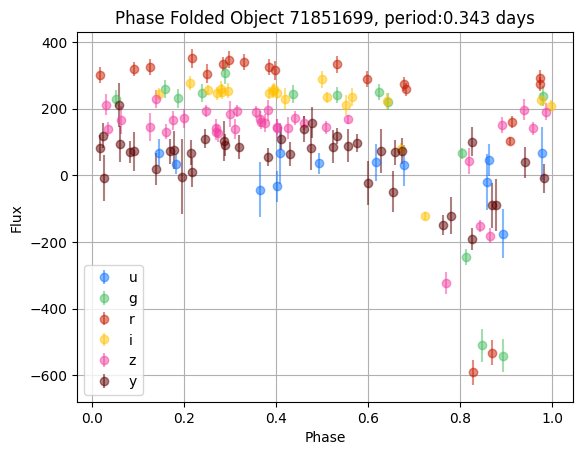

In [10]:
from astropy.timeseries import LombScargleMultiband

# Grab the source dataframe for the first object
obj = objsor_df.loc[71851699] #71851699
lc = obj.source

model = LombScargleMultiband(lc.mjd, lc.flux, lc.passband, lc.flux_err, nterms_base=2, nterms_band=1)
frequency, power = model.autopower(method='flexible', nyquist_factor=50)
freq_maxpower = frequency[np.argmax(power)]
t_phase = np.linspace(0, 1/freq_maxpower, 100)
y_fit = model.model(t_phase, freq_maxpower)

COLORS = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00',
          'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

#plt.plot(frequency, power)

for band in np.unique(lc.passband):
    band_mask = lc.passband == band
    band_labels = ["u","g","r","i","z","y"]
    #plt.plot(t_phase/(1/freq_maxpower), y_fit[band], '-', color=COLORS[band_labels[band]])
    plt.errorbar(lc.mjd[band_mask]%(1/freq_maxpower)/(1/freq_maxpower), 
                 lc.flux[band_mask], 
                 yerr=lc.flux_err[band_mask], 
                 fmt='o', alpha=0.5, 
                 label=band_labels[band], 
                 color=COLORS[band_labels[band]])

plt.title(f"Phase Folded Object {obj.name}, period:{np.round(1/freq_maxpower,3)} days")
plt.ylabel("Flux")
plt.xlabel("Phase")
plt.grid()
plt.legend()


## Nested Scientific Highlights

### ~1B Lightcurve Periodograms with Zwicky Transient Facility DR14

We ran a full periodogram analysis using the Pittsburgh Supercomputer Center using LSDB (with direct `nested-dask` integration). Running a low-resolution Lomb-Scargle algorithm completed in ~90 minutes with the following cluster setup:

* SLURM
* 50 Workers
* 3 Threads Per Worker
* 32 GB Memory Per Worker

<center><img src="./1B_ztf.png"/></center>

### Using Nested for Analysis of Nancy Grace Roman Space Telescope (NGRST) Simulation Data:

Presented at a recent AAS Meeting https://aas245-aas.ipostersessions.com/Default.aspx?s=8C-77-5D-99-C4-BD-11-BC-3A-7D-15-E3-43-D0-7F-1F

### Using Nested for Exploring Variable Candidates in COMCAM data

TODO: What can I show here

## Summary & Highlighting Usage
We believe that Nested-Pandas delivers a data representation and API that more naturally supports time-domain science, and even potentially other types of analysis that work with similarly structured data (spectra). Nested-Dask is a natural extension, that provides the scalability tooling neccesary for Rubin data volumes.

### Internal Usage
Nested-Pandas & Nested-Dask are used internally in other LINCC-Frameworks project, including direct integration in LSDB as well as usage within tdastro


### External Usage Highlights
* AAS Poster using Nested to support analysis with the Nancy Grace Roman Space Telescope's High Latitude Time-Domain Survey (HLTDS) Simulations: https://aas245-aas.ipostersessions.com/Default.aspx?s=8C-77-5D-99-C4-BD-11-BC-3A-7D-15-E3-43-D0-7F-1F 

* Main sequence Dipper Finding on HATS-formatted Zwicky Transient Facility (ZTF) Survey, as will be highlighted in the upcoming science talk from Andy Tzanidakis.